In [1]:
import os

import tqdm
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn

import vari
import vari.datasets
import vari.models
import vari.inference
import vari.layers

In [2]:
experiments_dir = '/nas/experiments/sacred/models/'
mpl.style.use('default')

## Visualize dataset

In [3]:
train_dataset = vari.datasets.Spirals(n_samples=10000, noise=0.05, rotation=0, start_radius=np.pi, rounds=1)
x_train = train_dataset.examples
y_train = train_dataset.labels
y_train = np.argmax(y_train, -1)
y_train_onehot = np.eye(2)[y_train]

In [4]:
test1_dataset = vari.datasets.Spirals(n_samples=10000, noise=0.05, rotation=np.pi/2, start_radius=0, rounds=1.5)
x_test1 = test1_dataset.examples
y_test1 = test1_dataset.labels
y_test1 = np.argmax(y_test1, -1)
y_test1_onehot = np.eye(2)[y_test1]

In [5]:
def make_meshgrid(x_lim, y_lim, nx=50, ny=50):
    """Returns a meshgrid over the 2D range specified by x_lim and y_lim"""
    x = np.linspace(*x_lim, nx)
    y = np.linspace(*y_lim, ny)
    xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
    x_meshgrid = []
    for i in range(nx):   
        for j in range(ny):
            x_meshgrid += [[xv[j,i], yv[j,i]]]
            if not i == 0:
                x_meshgrid += [[xv[j,i-1], yv[j,i-1]]]
            x_meshgrid += [[xv[j,i], yv[j,i]]]
            if not j == 0:
                x_meshgrid += [[xv[j-1,i], yv[j-1,i]]]
            x_meshgrid += [[xv[j,i], yv[j,i]]]
            if j == ny-1:
                for k in range(ny):
                    x_meshgrid += [[xv[ny-(k+1),i], yv[ny-(k+1),i]]]

    return np.array(x_meshgrid)

In [6]:
x_train_meshgrid = make_meshgrid(
    x_lim=(-1.5, 1.5),  # x_lim=(x_test1[:,0].min(), x_test1[:,0].max()),
    y_lim=(-1.5, 1.5),  # y_lim=(x_test1[:,1].min(), x_test1[:,1].max()),
    nx=50,
    ny=50
)

In [7]:
x_train_meshgrid_large = make_meshgrid(
    x_lim=(-4, 4),
    y_lim=(-4, 4),
    nx=150,
    ny=150
)

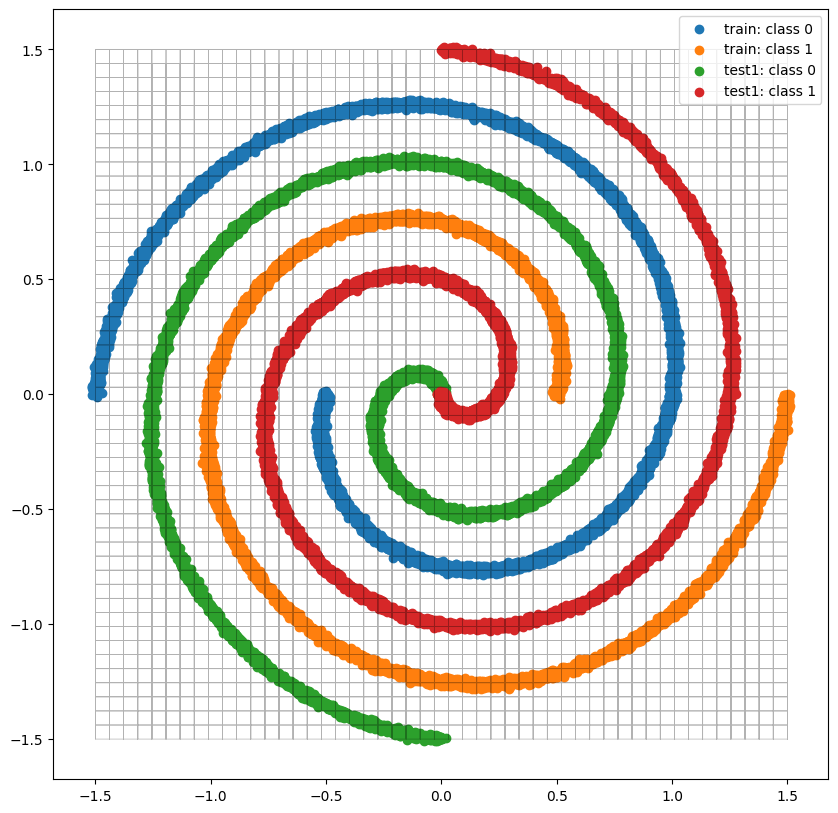

In [8]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(x_train_meshgrid[:,0], x_train_meshgrid[:,1], c="black", alpha=.3, linewidth=.5)
ax1.scatter(x_train[y_train==0,0], x_train[y_train==0,1], c='C0', label="train: class 0")
ax1.scatter(x_train[y_train==1,0], x_train[y_train==1,1], c='C1', label="train: class 1")
ax1.scatter(x_test1[y_test1==0,0], x_test1[y_test1==0,1], c='C2', label="test1: class 0")
ax1.scatter(x_test1[y_test1==1,0], x_test1[y_test1==1,1], c='C3', label="test1: class 1")
ax1.legend()
fig.show()

## Load models

### VAE

In [48]:
vae_run_id = 5964  # WORKS ()
vae_run_id = 5963  # WORKS (a1d74db5eb1a6605014c9b6169187f1a7228b78c)
vae_run_id = 5961  # BROKEN (238727264fff621de937bcf79807d3ac9fd979a3) newest
vae_run_id = 5965 # BROKEN (238727264fff621de937bcf79807d3ac9fd979a3) with sum instead of mean on logsumexp
vae_run_id = 5967  # XXXXX (154ff0157ae8b38b7a9370445932be9389790995)

In [49]:
vae = vari.models.VariationalAutoencoder(x_dim=2, z_dim=2, h_dims=[64, 64, 64])
vae.load_state_dict(torch.load(
    os.path.join(experiments_dir, str(vae_run_id), 'model_state_dict.pkl'),
    map_location=torch.device('cpu')
))

<All keys matched successfully>

### AVAE

In [50]:
avae_run_id = 5958

In [51]:
avae = vari.models.AuxilliaryVariationalAutoencoder(x_dim=2, z_dim=2, a_dim=3, h_dims=[64, 64, 64])
avae.load_state_dict(torch.load(
    os.path.join(experiments_dir, str(avae_run_id), 'model_state_dict.pkl'),
    map_location=torch.device('cpu')
))

<All keys matched successfully>

In [52]:
models = dict(
    vae=vae,
    avae=avae
)

## Visualize latent space

In [53]:
def plot_vectors_and_mesh(vectors, mesh, fig=None, ax=None, figsize=(20, 20), color='C0', alpha=0.4, label='train', label_ids=None):
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)
        
    if label_ids is not None:
        for i in np.unique(label_ids):
            ax.scatter(vectors[label_ids==i, 0], vectors[label_ids==i, 1], c=f'C{i}', alpha=alpha, label=f"{label}:class{i}")
    else:
        ax.scatter(vectors[:,0], vectors[:,1], c=color, alpha=alpha, label=label)
    #ax1.scatter(vae_qz_mu_x2[:,0], vae_qz_mu_x2[:,1], c=[test1_0], alpha=0.4, label="test1")
    ax.plot(mesh[:,0], mesh[:,1], c='black', alpha=.2, linewidth=.5)
    ax.scatter(mesh[:,0], mesh[:,1], c=[(.8, .8, .8, .8)], alpha=.5, s=5.)
    # ax1.axis('off')
    ax.legend()
    return fig, ax

### VAE

In [54]:
with torch.no_grad():
    vae_qz_x_train, vae_qz_mu_x_train, vae_qz_log_var_x_train = vae.decoder(torch.FloatTensor(train_dataset.examples))
    vae_qz_x_test1, vae_qz_mu_x_test1, vae_qz_log_var_x_test1 = vae.decoder(torch.FloatTensor(test1_dataset.examples))
    vae_qz_mesh, vae_qz_mu_mesh, vae_qz_log_var_mesh = vae.decoder(torch.FloatTensor(x_train_meshgrid))

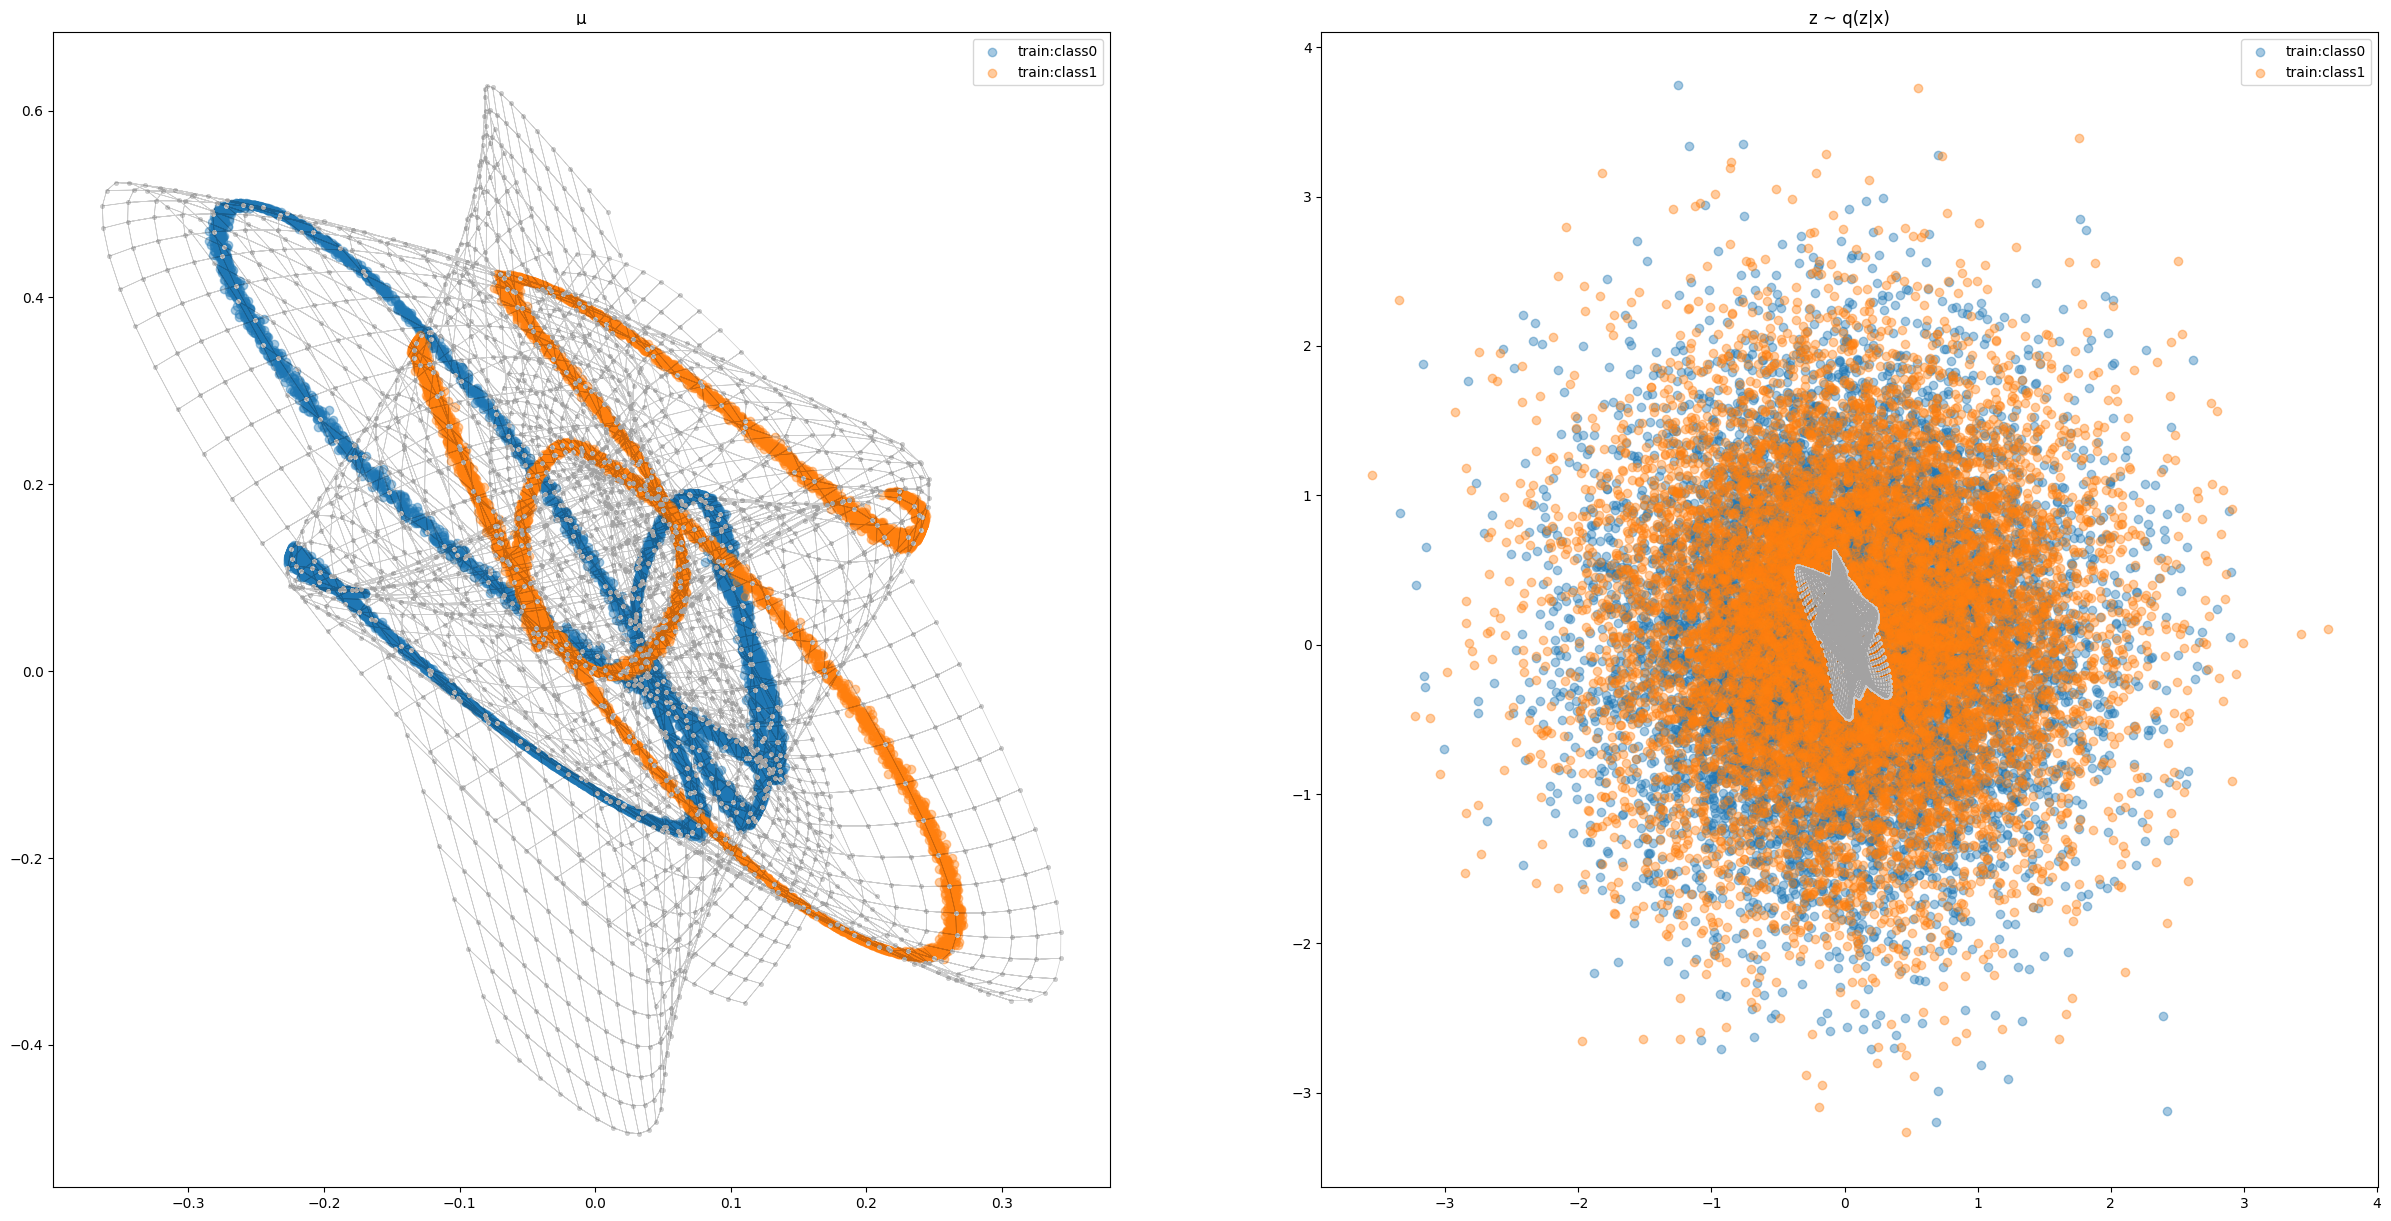

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
plot_vectors_and_mesh(vae_qz_mu_x_train, vae_qz_mu_mesh, label_ids=y_train, ax=ax1)
plot_vectors_and_mesh(vae_qz_x_train, vae_qz_mu_mesh, label_ids=y_train, ax=ax2)
ax1.set_title('µ')
ax2.set_title('z ~ q(z|x)')
plt.show()

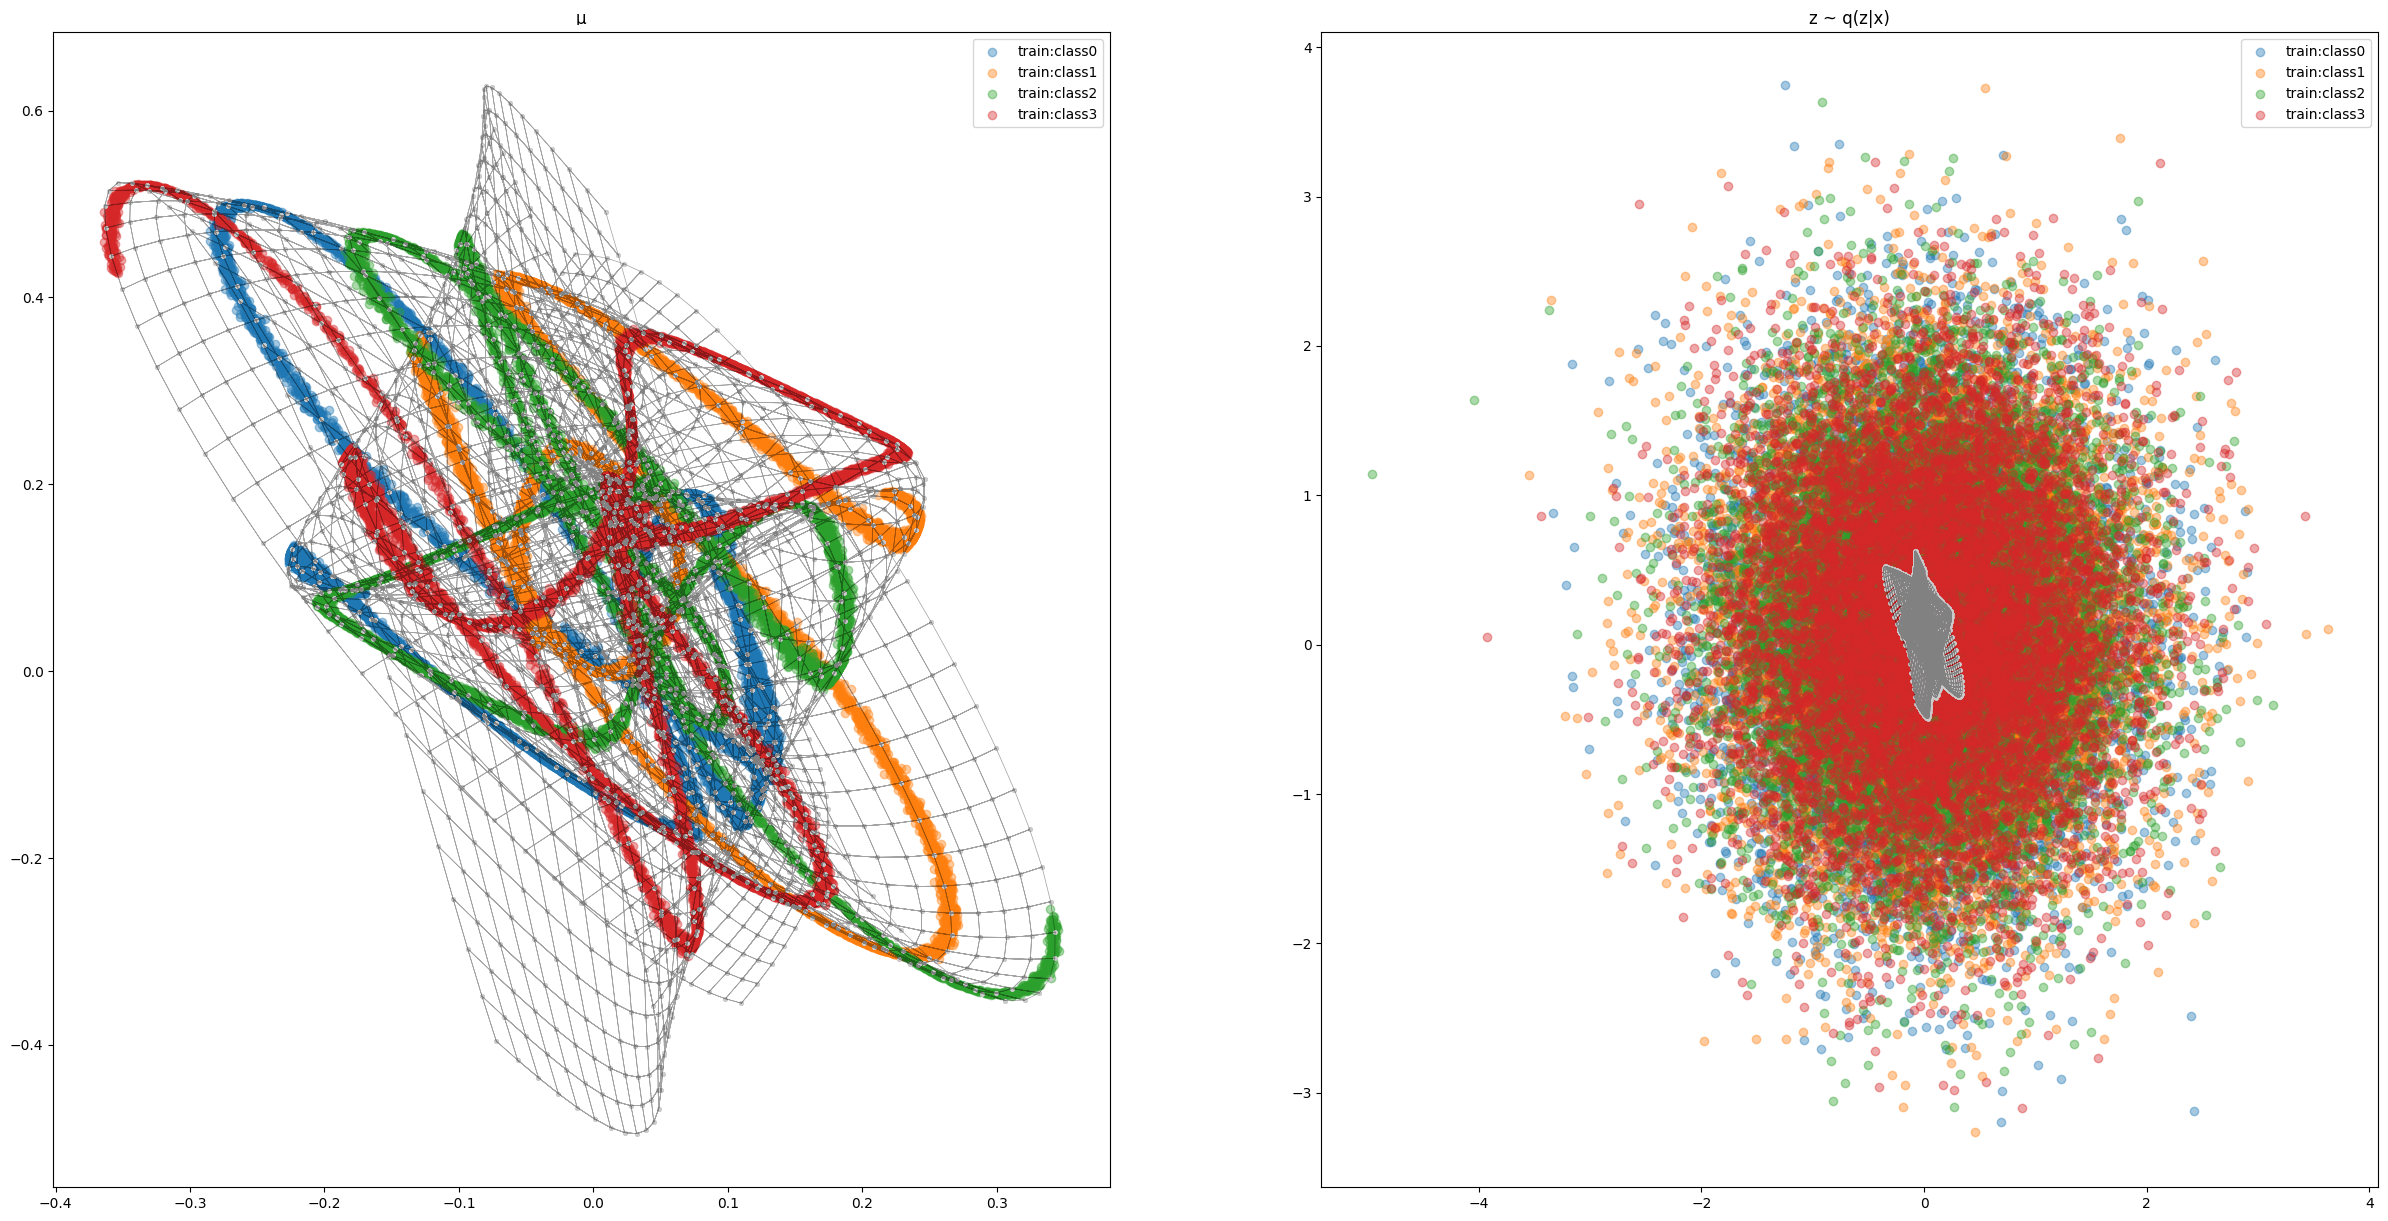

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
plot_vectors_and_mesh(vae_qz_mu_x_train, vae_qz_mu_mesh, label_ids=y_train, ax=ax1)
plot_vectors_and_mesh(vae_qz_mu_x_test1, vae_qz_mu_mesh, label_ids=y_test1+2, ax=ax1)
plot_vectors_and_mesh(vae_qz_x_train, vae_qz_mu_mesh, label_ids=y_train, ax=ax2)
plot_vectors_and_mesh(vae_qz_x_test1, vae_qz_mu_mesh, label_ids=y_test1+2, ax=ax2)
ax1.set_title('µ')
ax2.set_title('z ~ q(z|x)')
plt.show()

### AVAE

In [57]:
with torch.no_grad():
    avae_qz_x_train, avae_qz_mu_x_train, avae_qz_log_var_x_train = avae.decoder(torch.FloatTensor(train_dataset.examples))
    avae_qz_x_test1, avae_qz_mu_x_test1, avae_qz_log_var_x_test1 = avae.decoder(torch.FloatTensor(test1_dataset.examples))
    avae_qz_mesh, avae_qz_mu_mesh, avae_qz_log_var_mesh = avae.decoder(torch.FloatTensor(x_train_meshgrid))

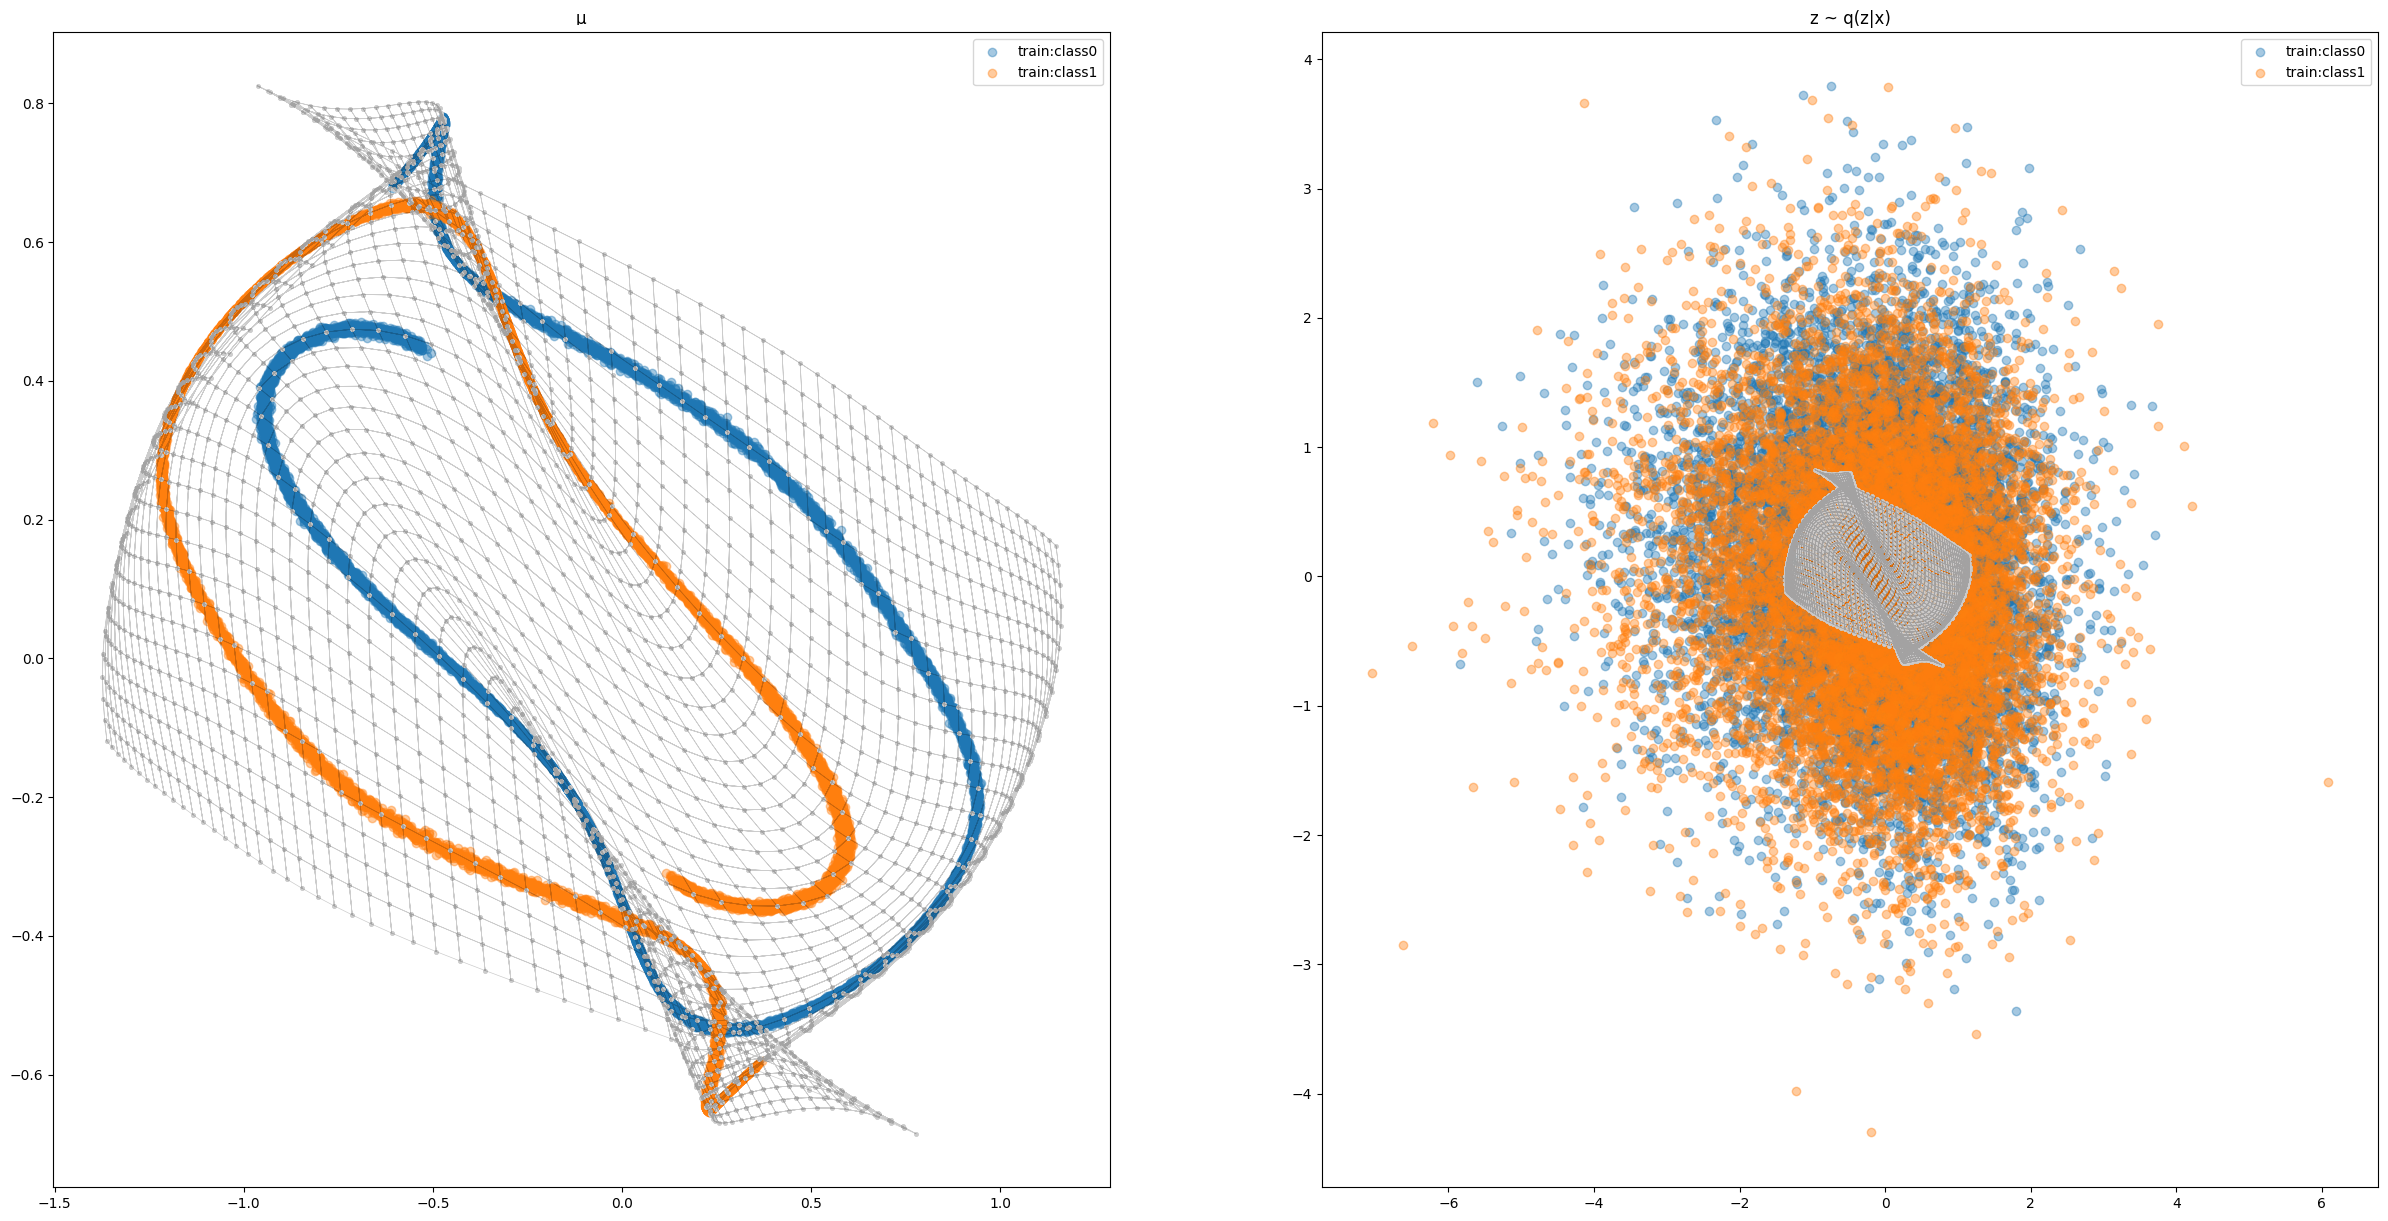

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
plot_vectors_and_mesh(avae_qz_mu_x_train, avae_qz_mu_mesh, label_ids=y_train, ax=ax1)
plot_vectors_and_mesh(avae_qz_x_train, avae_qz_mu_mesh, label_ids=y_train, ax=ax2)
ax1.set_title('µ')
ax2.set_title('z ~ q(z|x)')
plt.show()

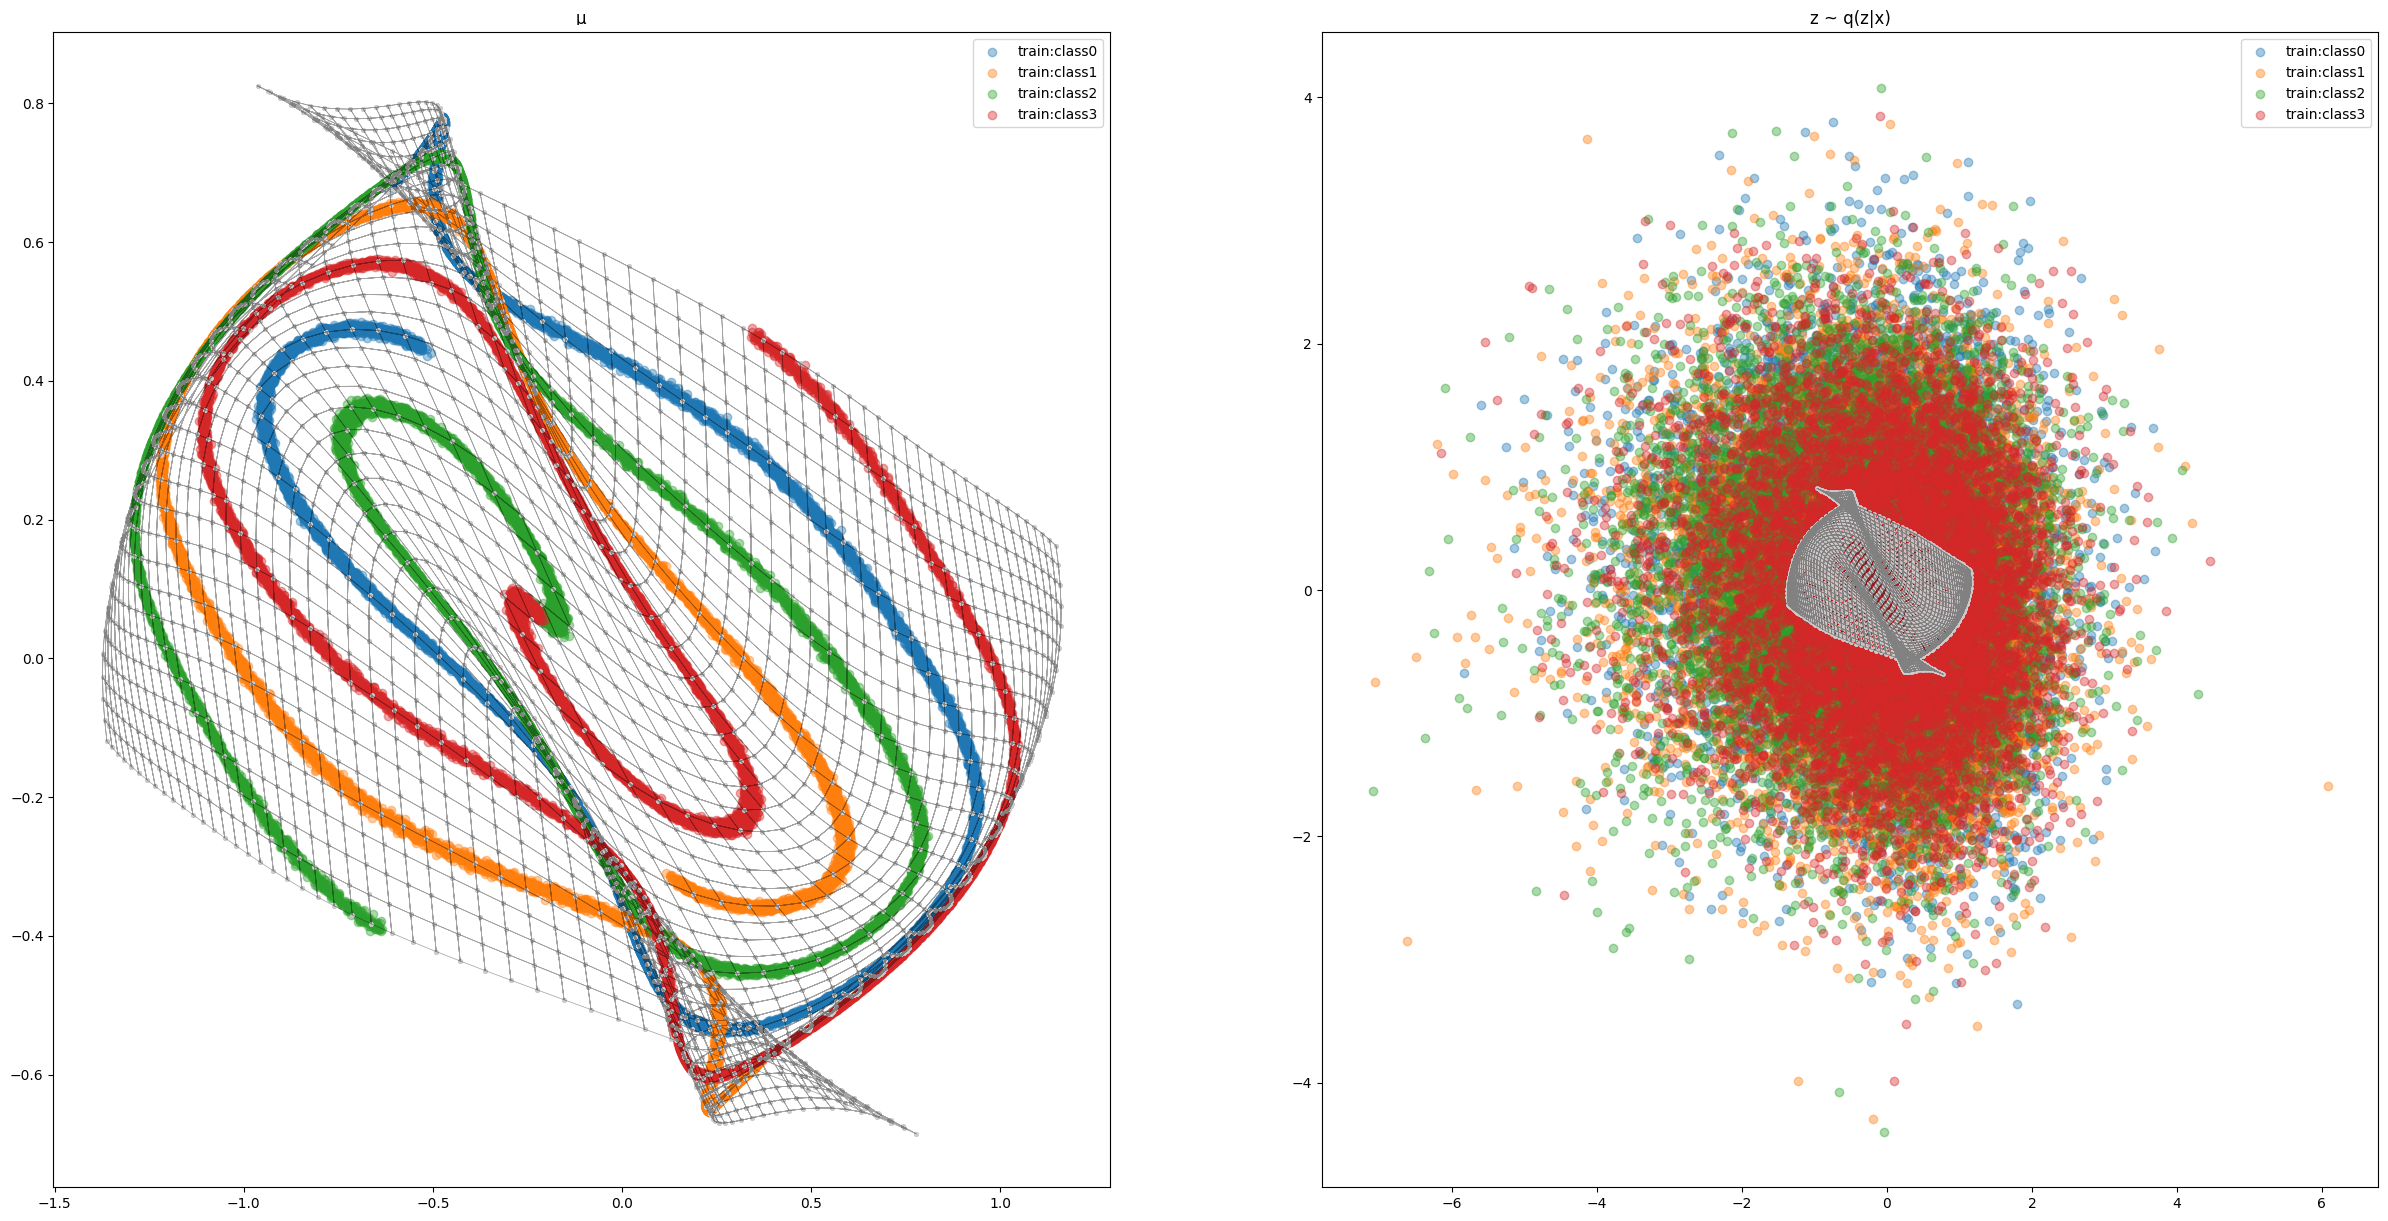

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
plot_vectors_and_mesh(avae_qz_mu_x_train, avae_qz_mu_mesh, label_ids=y_train, ax=ax1)
plot_vectors_and_mesh(avae_qz_mu_x_test1, avae_qz_mu_mesh, label_ids=y_test1+2, ax=ax1)
plot_vectors_and_mesh(avae_qz_x_train, avae_qz_mu_mesh, label_ids=y_train, ax=ax2)
plot_vectors_and_mesh(avae_qz_x_test1, avae_qz_mu_mesh, label_ids=y_test1+2, ax=ax2)
ax1.set_title('µ')
ax2.set_title('z ~ q(z|x)')
plt.show()

## Visualize reconstruction

In [71]:
n_samples = 1000
x_originals = torch.FloatTensor(train_dataset.examples[:n_samples])
with torch.no_grad():
    vae_p_x_reconstructions, vae_p_x_mu, vae_p_x_log_var = vae(x_originals)
    avae_p_x_reconstructions, avae_p_x_mu, avae_p_x_log_var = avae(x_originals)

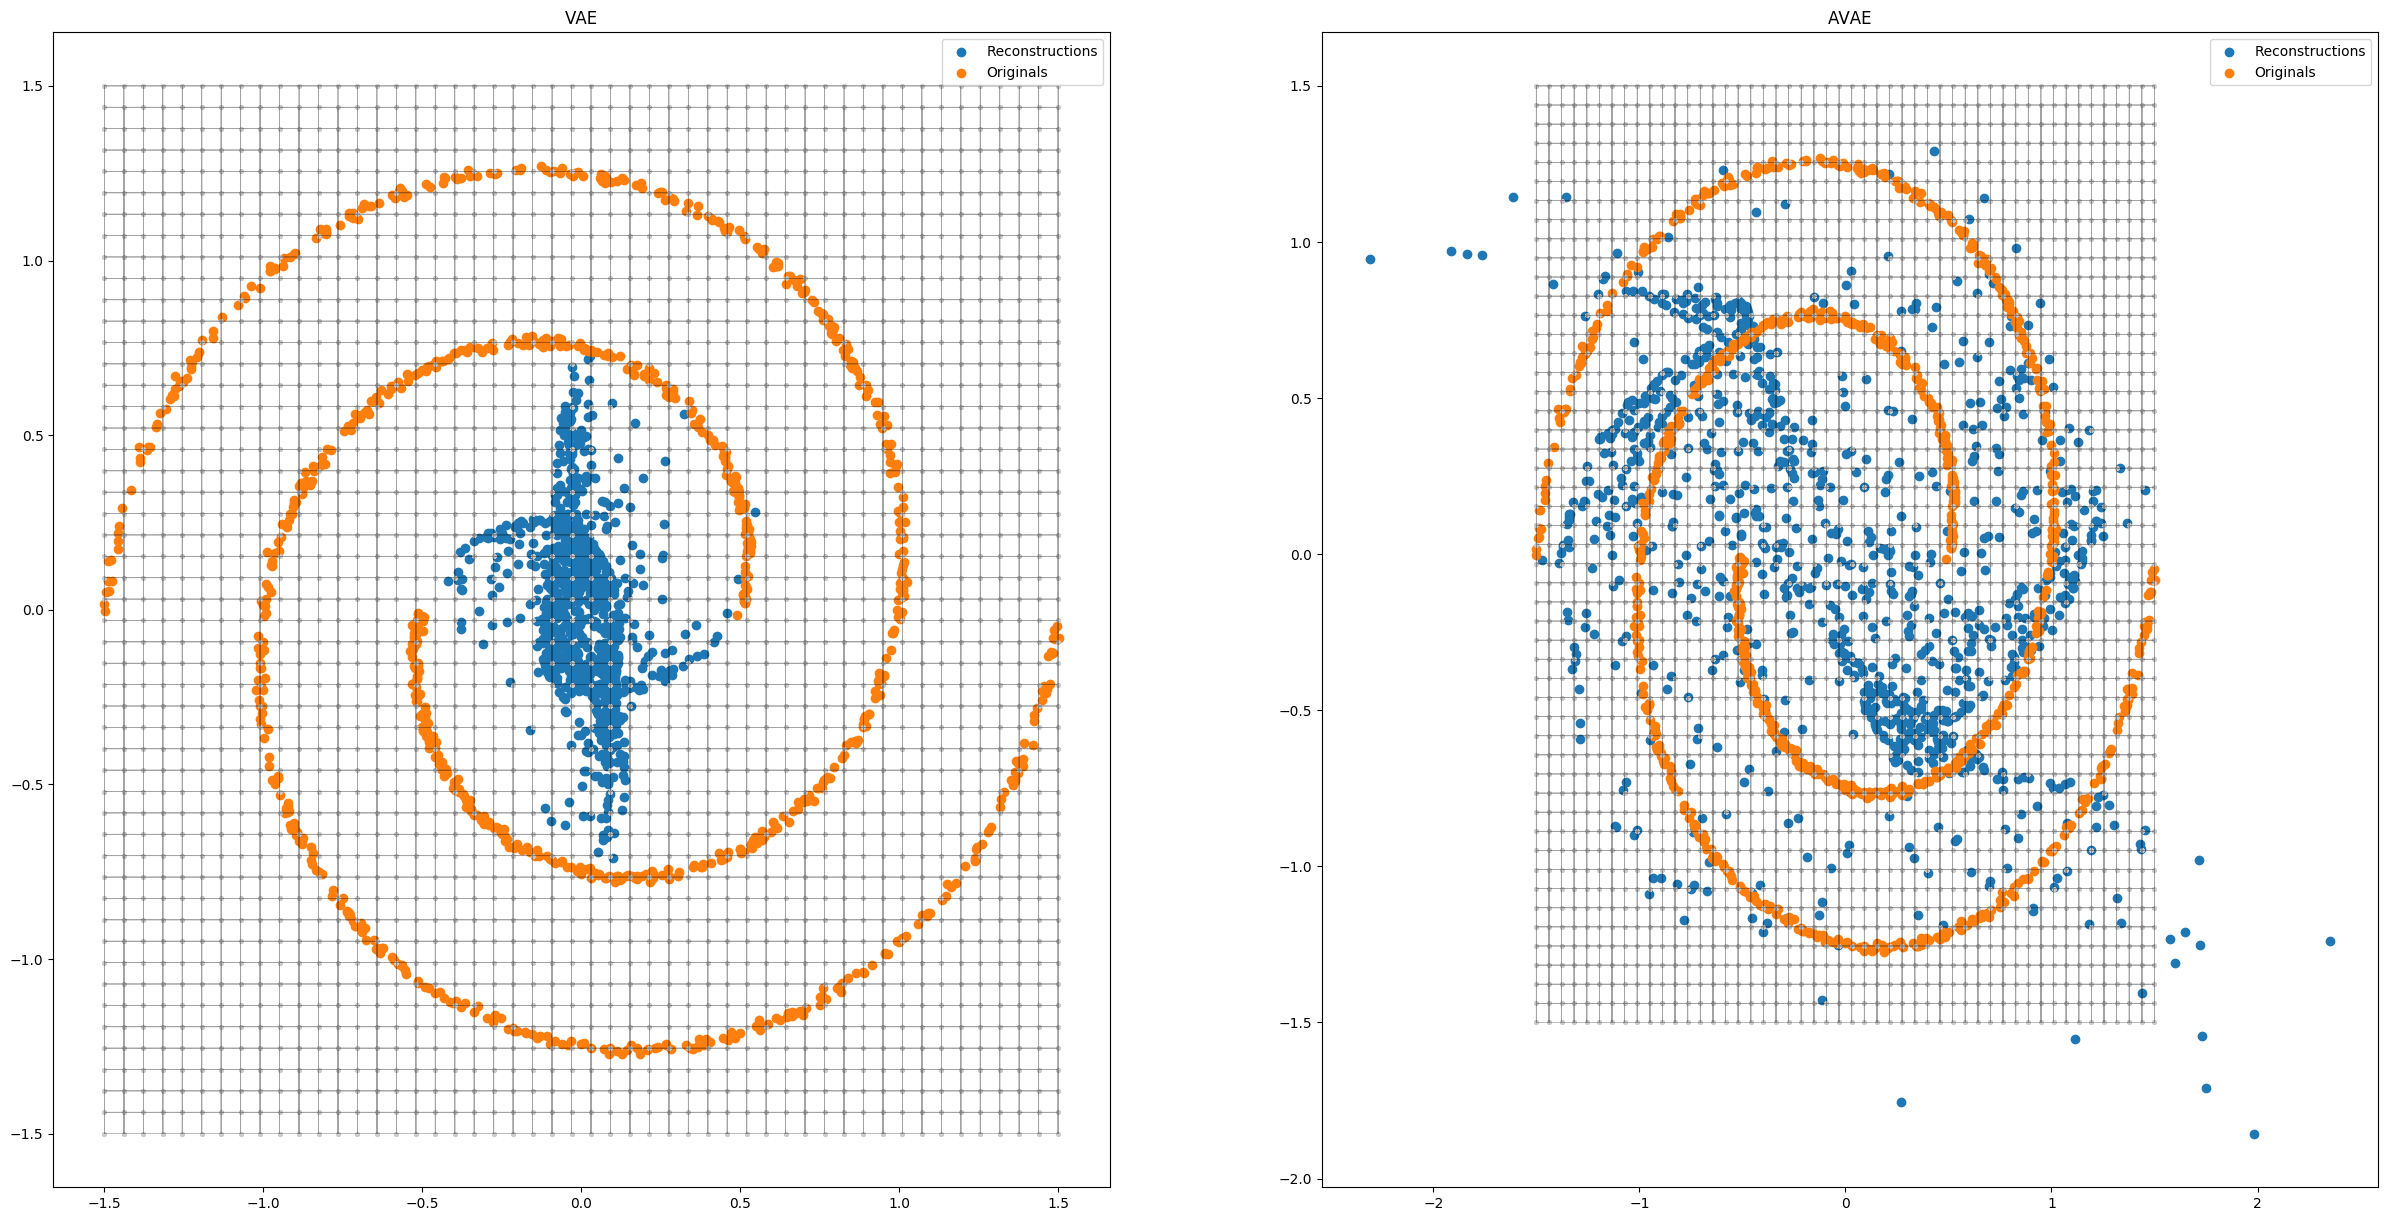

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
plot_vectors_and_mesh(vae_p_x_mu, x_train_meshgrid, alpha=1, label='Reconstructions', ax=ax1)
plot_vectors_and_mesh(x_originals, x_train_meshgrid, alpha=1, color='C1', label='Originals', ax=ax1)
plot_vectors_and_mesh(avae_p_x_mu, x_train_meshgrid, alpha=1, label='Reconstructions', ax=ax2)
plot_vectors_and_mesh(x_originals, x_train_meshgrid, alpha=1, color='C1', label='Originals', ax=ax2)
ax1.set_title('VAE')
ax2.set_title('AVAE')
plt.show()

## Visualize sampling

In [73]:
n_samples = 10000
p_z_samples = torch.randn((n_samples, 2))

In [74]:
with torch.no_grad():
    vae_p_x_samples, vae_p_x_mu, vae_p_x_log_var = vae.decoder(p_z_samples)
    avae_p_x_samples, avae_p_x_mu, avae_p_x_log_var = avae.decoder(p_z_samples)

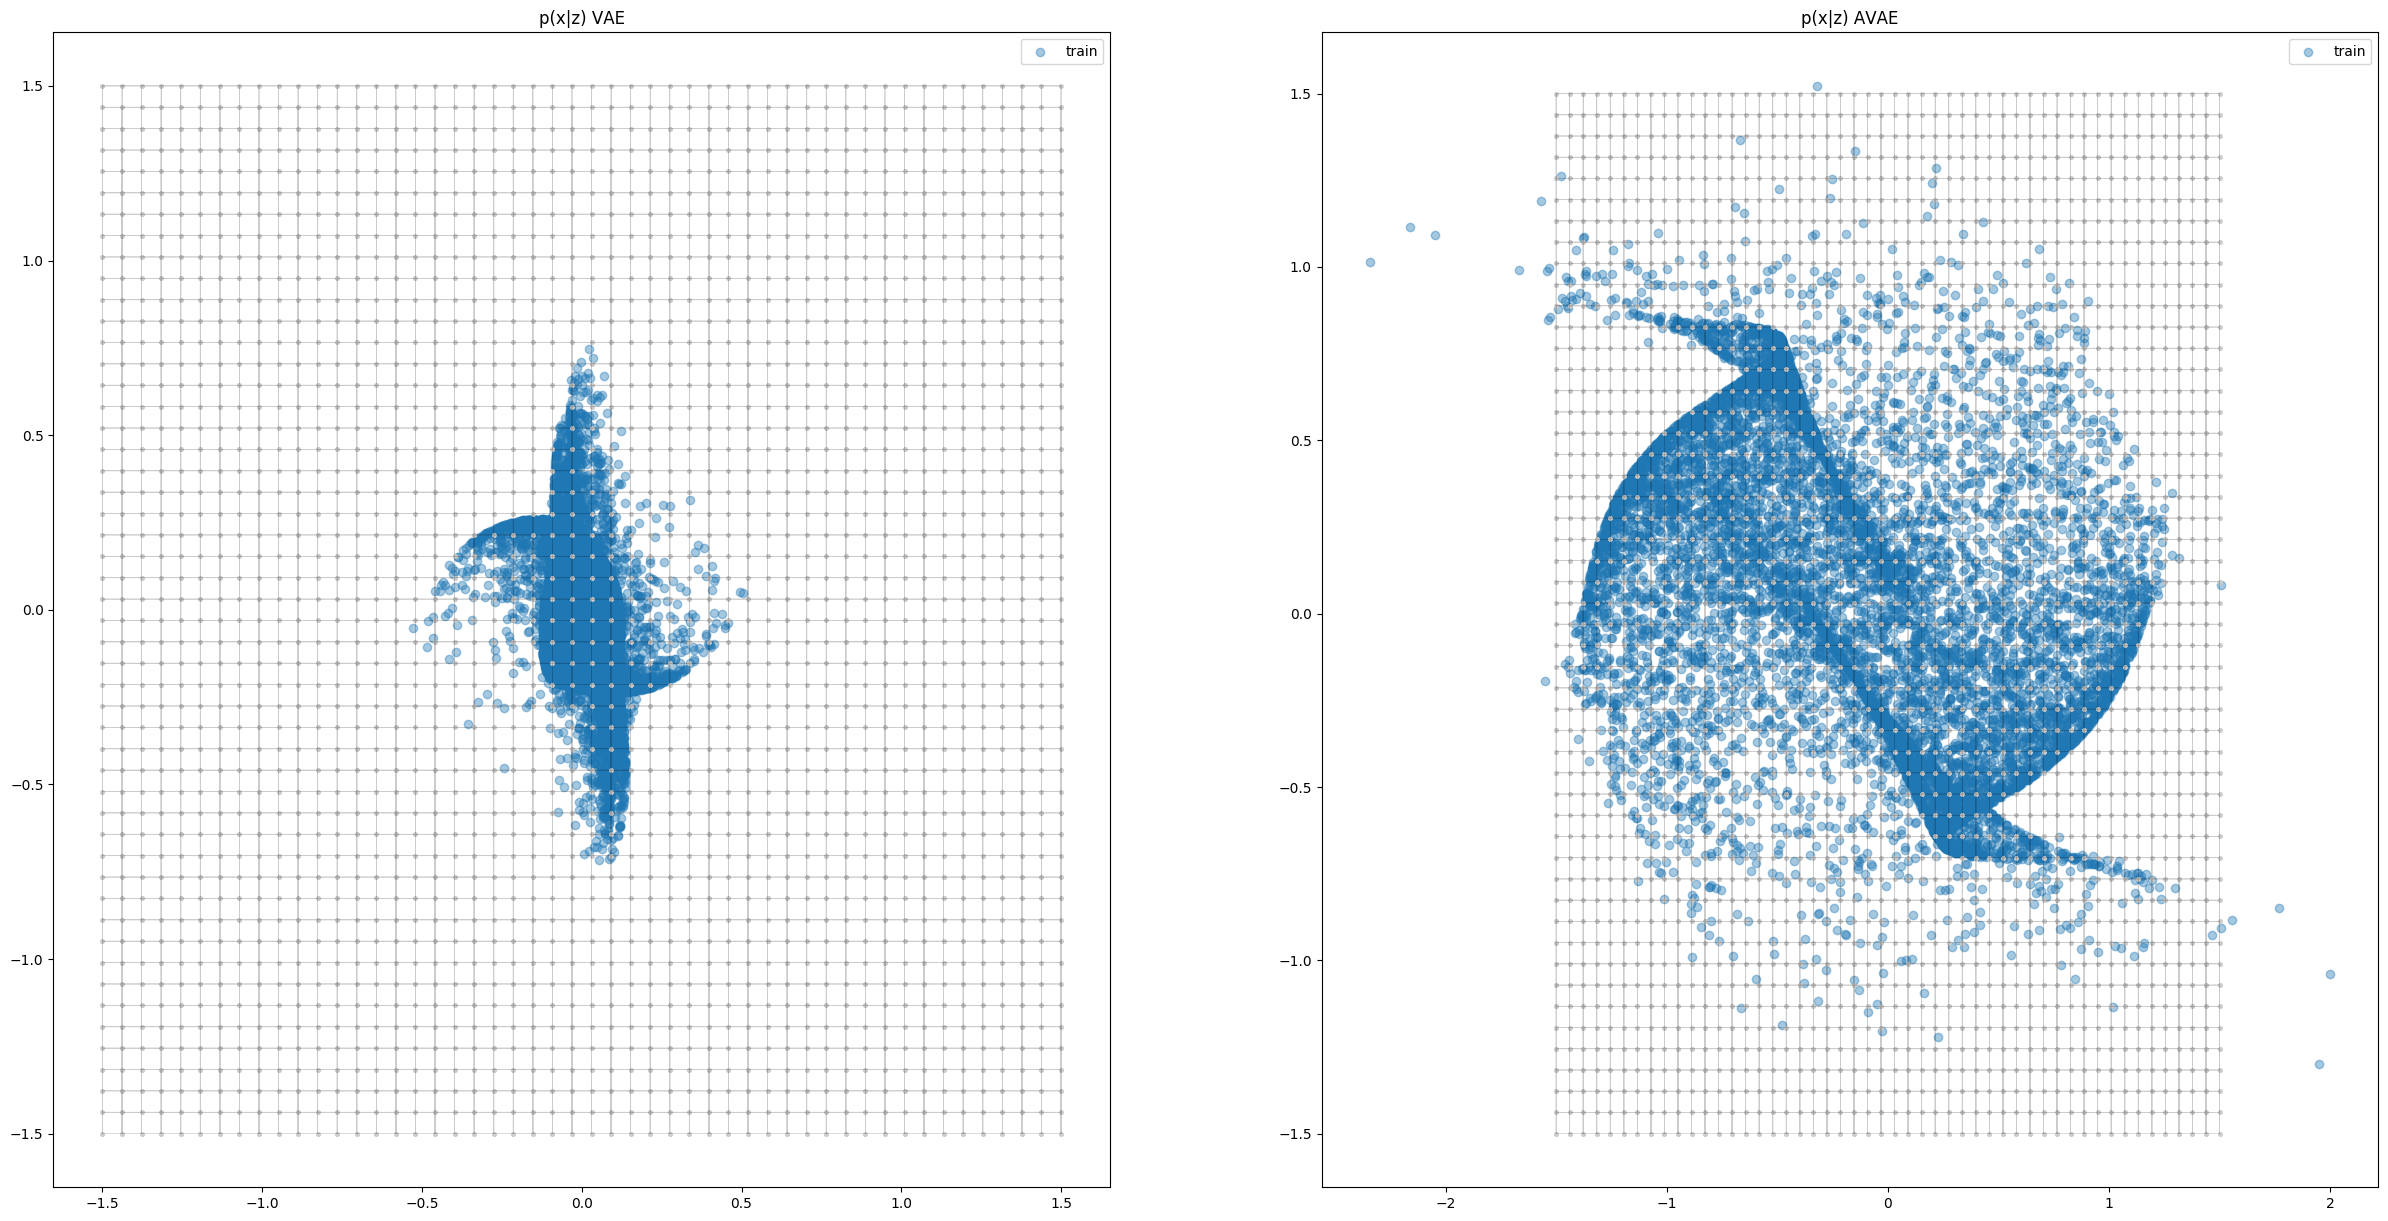

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
plot_vectors_and_mesh(vae_p_x_mu, x_train_meshgrid, ax=ax1)
plot_vectors_and_mesh(avae_p_x_mu, x_train_meshgrid, ax=ax2)
ax1.set_title('p(x|z) VAE')
ax2.set_title('p(x|z) AVAE')
plt.show()

## Visualize density by ELBO

In [26]:
nx, ny = (500, 500)
importance_samples = 100

x_min, x_max, y_min, y_max = [-2, 2, -2, 2]
x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)
xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
zv = np.zeros(xv.shape)
zv_var = np.zeros(xv.shape)
with torch.no_grad():
    for j in tqdm.tqdm(range(x.shape[0])):
        inp = np.append(xv[:, j:j+1], yv[:, j:j+1], axis=1)
        inp = torch.FloatTensor(inp)
#        inp = inp.repeat(importance_samples, 1)
        inp = inp.repeat(1, importance_samples).view(-1, inp.shape[1])
        
        px, px_mu, px_sigma = vae.forward(torch.FloatTensor(inp))
        
        kl_divergence = vae.kl_divergence
        likelihood = vari.inference.log_gaussian(px, px_mu, px_sigma)
        elbo = likelihood - kl_divergence
        
        elbo_mean = vari.utilities.log_sum_exp(elbo.view(-1, importance_samples, 1), axis=1, sum_op=torch.mean).view(-1)  # (B, 1, 1)

        zv[:, j] = elbo_mean
        zv_var[:, j] = elbo_var

  0%|          | 0/500 [00:00<?, ?it/s]


NameError: name 'elbo_var' is not defined

In [ ]:
zv_rescaled = zv

#zv_rescaled += zv.min()

zv_rescaled = np.clip(zv_rescaled, -20000., zv_rescaled.max()) # TODO: Do something smarter here!

#zv_rescaled = np.clip(zv_rescaled, 15., zv_rescaled.max())

#zv_rescaled = (zv_rescaled - zv_rescaled.min()) / (zv_rescaled.max() - zv_rescaled.min())
#zv_rescaled = 1-zv_rescaled

#zv_rescaled = np.exp(zv)

plt.figure(figsize=(40, 40))
plt.imshow(zv_rescaled, mpl.cm.get_cmap('binary_r'))
plt.colorbar()
plt.axis(aspect='image');
#plt.axis('off')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
seaborn.distplot(zv.flatten(), ax=ax)

## OOD detection based on ELBO

In [76]:
def compute_elbo_no_iw(model, x):
    with torch.no_grad():
        x = torch.FloatTensor(x)
        
        px, px_mu, px_sigma = model.forward(x)
        
        kl_divergence = vae.kl_divergence
        likelihood = vari.inference.log_gaussian(px, px_mu, px_sigma)
        elbo = likelihood - kl_divergence
        
        return elbo, kl_divergence, likelihood

def compute_elbo_iw(model, x, importance_samples=1):
    with torch.no_grad():
        x = torch.FloatTensor(x)
        x = x.repeat(1, importance_samples).view(-1, x.shape[1])
        
        px, px_mu, px_sigma = model.forward(x)
        
        kl_divergence = vae.kl_divergence
        likelihood = vari.inference.log_gaussian(px, px_mu, px_sigma)
        elbo = likelihood - kl_divergence
        
        elbo_mean = vari.utilities.log_sum_exp(elbo.view(-1, importance_samples, 1), axis=1, sum_op=torch.mean).view(-1)  # (B, 1, 1)
        lielihood_mean = vari.utilities.log_sum_exp(likelihood.view(-1, importance_samples, 1), axis=1, sum_op=torch.mean).view(-1)  # (B, 1, 1)
        kl_divergence_mean = vari.utilities.log_sum_exp(kl_divergence.view(-1, importance_samples, 1), axis=1, sum_op=torch.mean).view(-1)  # (B, 1, 1)

        return elbo_mean, kl_divergence, likelihood

def compute_elbo(model, x, importance_samples=0):
    if importance_samples == 0:
        return compute_elbo_no_iw(model, x)
    return compute_elbo_iw(model, x, importance_samples)

In [77]:
elbo_train, kl_train, likelihood_train = compute_elbo(avae, train_dataset.examples)
elbo_test1, kl_test1, likelihood_test1 = compute_elbo(avae, test1_dataset.examples)

RuntimeError: The size of tensor a (20000) must match the size of tensor b (1000) at non-singleton dimension 0

In [ ]:
elbo_train

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
seaborn.distplot(elbo_train.flatten(), ax=ax, label='train')
seaborn.distplot(elbo_test1, ax=ax, label='test1')
ax.legend()